In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [2]:
FILE_PATH = 'sonnets1.txt'
NUM_BATCHES = 16
LSTM_UNITS = 128
EMBEDDING_DIM = 100

In [3]:
# Read the data
with open(FILE_PATH) as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2465 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou contracted to thine own bright eyes,


In [5]:
def fit_vectorizer(corpus):
    """
    Instantiates the vectorizer class on the corpus

    Args:
        corpus (list): List with the sentences.

    Returns:
        (tf.keras.layers.TextVectorization): an instance of the TextVectorization class containing the word-index dictionary, adapted to the corpus sentences.
    """

    tf.keras.utils.set_random_seed(65) # Do not change this line or you may have different expected outputs throughout the assignment

    ### START CODE HERE ###

     # Define the object with appropriate parameters
    vectorizer = tf.keras.layers.TextVectorization(
        standardize='lower_and_strip_punctuation',  # Convert to lowercase and strip punctuation
        split='whitespace',  # Split on whitespace (default)
        ragged=True,  # Allow ragged tensors
        output_mode='int'  # Output as integers
    )

    # Adapt it to the corpus
    vectorizer.adapt(corpus)
    ### END CODE HERE ###

    return vectorizer

In [6]:
vectorizer = fit_vectorizer(corpus)
total_words = len(vectorizer.get_vocabulary())
print('Name:Meetha Prabhu     Register Number: 212222240065                ')
print(f"Total number of words in corpus (including the out of vocabulary): {total_words}")

Name:Meetha Prabhu     Register Number: 212222240065                
Total number of words in corpus (including the out of vocabulary): 3180


In [7]:
print('Name:Meetha Prabhu     Register Number: 212222240065                ')
print(f"Passing a string directly: {vectorizer('This is a test string').__repr__()}")
print(f"Passing a list of strings: {vectorizer(['This is a test string'])}")

Name:Meetha Prabhu     Register Number: 212222240065                
Passing a string directly: <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  30,   14,   18,    1, 1688])>
Passing a list of strings: <tf.RaggedTensor [[30, 14, 18, 1, 1688]]>


In [8]:
# GRADED FUNCTION: n_gram_seqs

def n_gram_seqs(corpus, vectorizer):
    """
    Generates a list of n-gram sequences

    Args:
        corpus (list of string): lines of texts to generate n-grams for
        vectorizer (tf.keras.layers.TextVectorization): an instance of the TextVectorization class adapted in the corpus

    Returns:
        (list of tf.int64 tensors): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    ### START CODE HERE ###
    for sentence in corpus:
        # Vectorize the sentence to get the token indices
        vectorized_sentence = vectorizer(sentence)

        # Generate n-grams for the vectorized sentence
        for i in range(2, vectorized_sentence.shape[0] + 1):  # Start from 2 to avoid the first token
            n_gram = vectorized_sentence[:i]
            input_sequences.append(n_gram)

    ### END CODE HERE ###

    return input_sequences

In [9]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, vectorizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])
print('Name:Meetha Prabhu     Register Number: 212222240065                ')
print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

Name:Meetha Prabhu     Register Number: 212222240065                
n_grams of input_sequences have length: 15428
maximum length of sequences is: 11


In [10]:
# GRADED FUNCTION: pad_seqs

def pad_seqs(input_sequences, max_sequence_len):
    """
    Pads tokenized sequences to the same length

    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences

    Returns:
        (np.array of int32): tokenized sequences padded to the same length
    """

   ### START CODE HERE ###
    # Convert tensors to lists if necessary
    input_list = [seq if isinstance(seq, list) else seq.numpy().tolist() for seq in input_sequences]

    # Use pad_sequences to pad the sequences with left padding ('pre')
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        input_list,              # Use the list of lists for padding
        maxlen=max_sequence_len,  # Set the maximum length
        padding='pre',            # Pad sequences to the left (before the sequence)
        dtype='int32'             # Specify the output type as int32
    )
    ### END CODE HERE ###

    return padded_sequences

In [11]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)
print('Name:Meetha Prabhu     Register Number: 212222240065')
print(f"padded corpus has shape: {input_sequences.shape}")

Name:Meetha Prabhu     Register Number: 212222240065                
padded corpus has shape: (15428, 11)


In [12]:
# GRADED FUNCTION: features_and_labels

def features_and_labels_dataset(input_sequences, total_words):
    """
    Generates features and labels from n-grams and returns a tensorflow dataset

    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size

    Returns:
        (tf.data.Dataset): Dataset with elements in the form (sentence, label)
    """
    ### START CODE HERE ###
    # Define the features by taking all tokens except the last one for each sequence
    features = [seq[:-1] for seq in input_sequences]

    # Define the labels by taking the last token for each sequence
    labels = [seq[-1] for seq in input_sequences]

    # One-hot encode the labels using total_words as the number of classes
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

    # Build the dataset using the features and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((features, one_hot_labels))

    # Batch the dataset with a batch size of 16
    batch_size = 16  # Feel free to adjust this based on the global variable, but should be <= 64
    batched_dataset = dataset.batch(batch_size)

    ### END CODE HERE ###

    return batched_dataset

In [13]:
# Split the whole corpus
dataset = features_and_labels_dataset(input_sequences, total_words).prefetch(tf.data.AUTOTUNE)
print('Name:Meetha Prabhu     Register Number: 212222240065')
print(f"Feature shape: {dataset.element_spec[0]}")
print(f"Label shape: {dataset.element_spec[1]}")

Name:Meetha Prabhu     Register Number: 212222240065
Feature shape: TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)
Label shape: TensorSpec(shape=(None, 3180), dtype=tf.float64, name=None)


In [14]:
# GRADED FUNCTION: create_model

def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model

    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences

    Returns:
       (tf.keras Model): the text generator model
    """
    model = tf.keras.Sequential()

   ### START CODE HERE ###
    # Input layer shape is max_sequence_len - 1 because we removed the last word as a label
    model.add(tf.keras.layers.Input(shape=(max_sequence_len - 1,)))

    # Embedding layer
    model.add(tf.keras.layers.Embedding(input_dim=total_words,
                                        output_dim=100,
                                        input_length=max_sequence_len - 1))

    # Add a Bidirectional LSTM layer with 150 units
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)))

    # Add a Dense layer with 'total_words' units and softmax activation
    model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    ### END CODE HERE ###

    return model

In [15]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
example_batch = dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (16, 3180)


In [17]:
# Train the model
history = model.fit(dataset, epochs=30, verbose=1)

Epoch 1/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.0277 - loss: 7.0351
Epoch 2/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.0323 - loss: 6.1059
Epoch 3/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - accuracy: 0.0441 - loss: 5.7217
Epoch 4/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.0521 - loss: 5.3645
Epoch 5/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.0642 - loss: 5.0802
Epoch 6/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.0726 - loss: 4.9574
Epoch 7/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - accuracy: 0.0895 - loss: 4.7916
Epoch 8/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.1118 - loss: 4.4815
Epoch 9/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.1594 - loss: 4.1288
Epoch 10/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.1898 - loss: 3.9328
Epoch 11/30
965/965 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.2368 - loss: 3.6830
Epoch 12/30
965/965 ━━━━━━━━━━

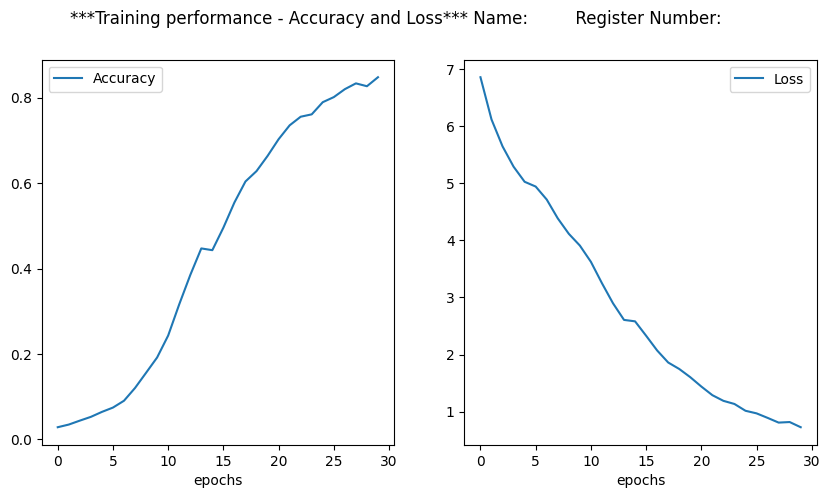

In [18]:
# Get training and validation accuracies
acc = history.history['accuracy']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('***Training performance - Accuracy and Loss*** Name:         Register Number:        ')

for i, (data, label) in enumerate(zip([acc,loss], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data, label=label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

In [19]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [20]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
    # Convert the text into sequences
    token_list = vectorizer(seed_text)
    # Pad the sequences
    token_list = tf.keras.utils.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict([token_list], verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = vectorizer.get_vocabulary()[predicted]
    # Append to the current text
    seed_text += " " + output_word
print('Name:Meetha Prabhu     Register Number: 212222240065')
print(seed_text)

Name:Meetha Prabhu     Register Number: 212222240065
Help me Obi Wan Kenobi, you're my only hope swearing quite prove prove behind cause of thee will to thee hate me well kind of me my mind to thee away i lie to thee me not die i lie with thee away i say this love me bright eye lies show thee me i know it be not then do i am forsworn to go perjured gone of mind thee dost call my mind thought me not misuse thee to me so prove me day to see ill be cured more more grace me to know it hate of you prove thee how well those lease of thee
